# Roshambo game : offline preliminary analysis

## Load the recorded data 

In [1]:
fname = "./../data/bitalino_emg_A12.hdf5" 

In [2]:
import pandas as pd

df_filtered = pd.read_hdf(fname, "/filtered")
events = pd.read_hdf(fname, "/events")

## Implement the node to extract the features 

In [3]:
import numpy as np

from timeflux.core.node import Node 
from timeflux.core.branch import Branch 

class EMGFeatures(Node):
    def update(self):
        outputs = {}
        for _, suffix, port in self.iterate("i*"):
            if port.ready():
                index = port.data.index.values[-1]
                list_features = []
                data = port.data
                list_features.append(data.std().add_suffix("_std"))
                list_features.append(data.max().add_suffix("_max"))
                list_features.append(
                    data.apply(self._zero_crossing_rate).add_suffix("_zcr")
                )
                outputs["o" + suffix] = {
                    "meta": port.meta,
                    "data": pd.concat(list_features).to_frame(index).T,
                }
        for port_name, port_data in outputs.items():
            o = getattr(self, port_name)
            o.data = port_data["data"]
            o.meta = port_data["meta"]

    @staticmethod
    def _zero_crossing_rate(x):
        return len(np.where(np.diff(np.sign(x)))[0]) / len(x)
    
features_node = EMGFeatures()

In [4]:
from timeflux.nodes.epoch import Epoch

epoch = Epoch(before=0.0, after=3.0, event_trigger="trial_starts")
epoch.i.data = df_filtered
epoch.i_events.data = events
epoch.update()

In [5]:
epochs = []
features = []
labels = []
for port_name, _, port in epoch.iterate():
    label = port.meta.get("epoch", {}).get("context", {}).get("id")
    if label:
        epochs.append(port.data) 
        features_node.i.data = port.data
        features_node.update()
        features.append(features_node.o.data)
        labels.append(label)
df_features = pd.concat(features)
df_features["label"] = labels
df_features.head()

,A1_EMG_std,A2_EMG_std,A1_EMG_max,A2_EMG_max,A1_EMG_zcr,A2_EMG_zcr,label
2022-10-12 14:59:07.755282,0.013193,0.136665,0.057161,0.788612,0.214333,0.286000,scissors
2022-10-12 14:59:12.759282,0.077112,0.162860,0.329431,0.654911,0.222333,0.278000,rock
2022-10-12 14:59:17.760282,0.017896,0.020132,0.070189,0.098716,0.238667,0.280667,paper
2022-10-12 14:59:22.763282,0.005624,0.002516,0.041189,0.008731,0.222000,0.289333,rest
2022-10-12 14:59:27.765282,0.004155,0.002885,0.015588,0.019747,0.237000,0.281667,rest


## Visualize the features distributions

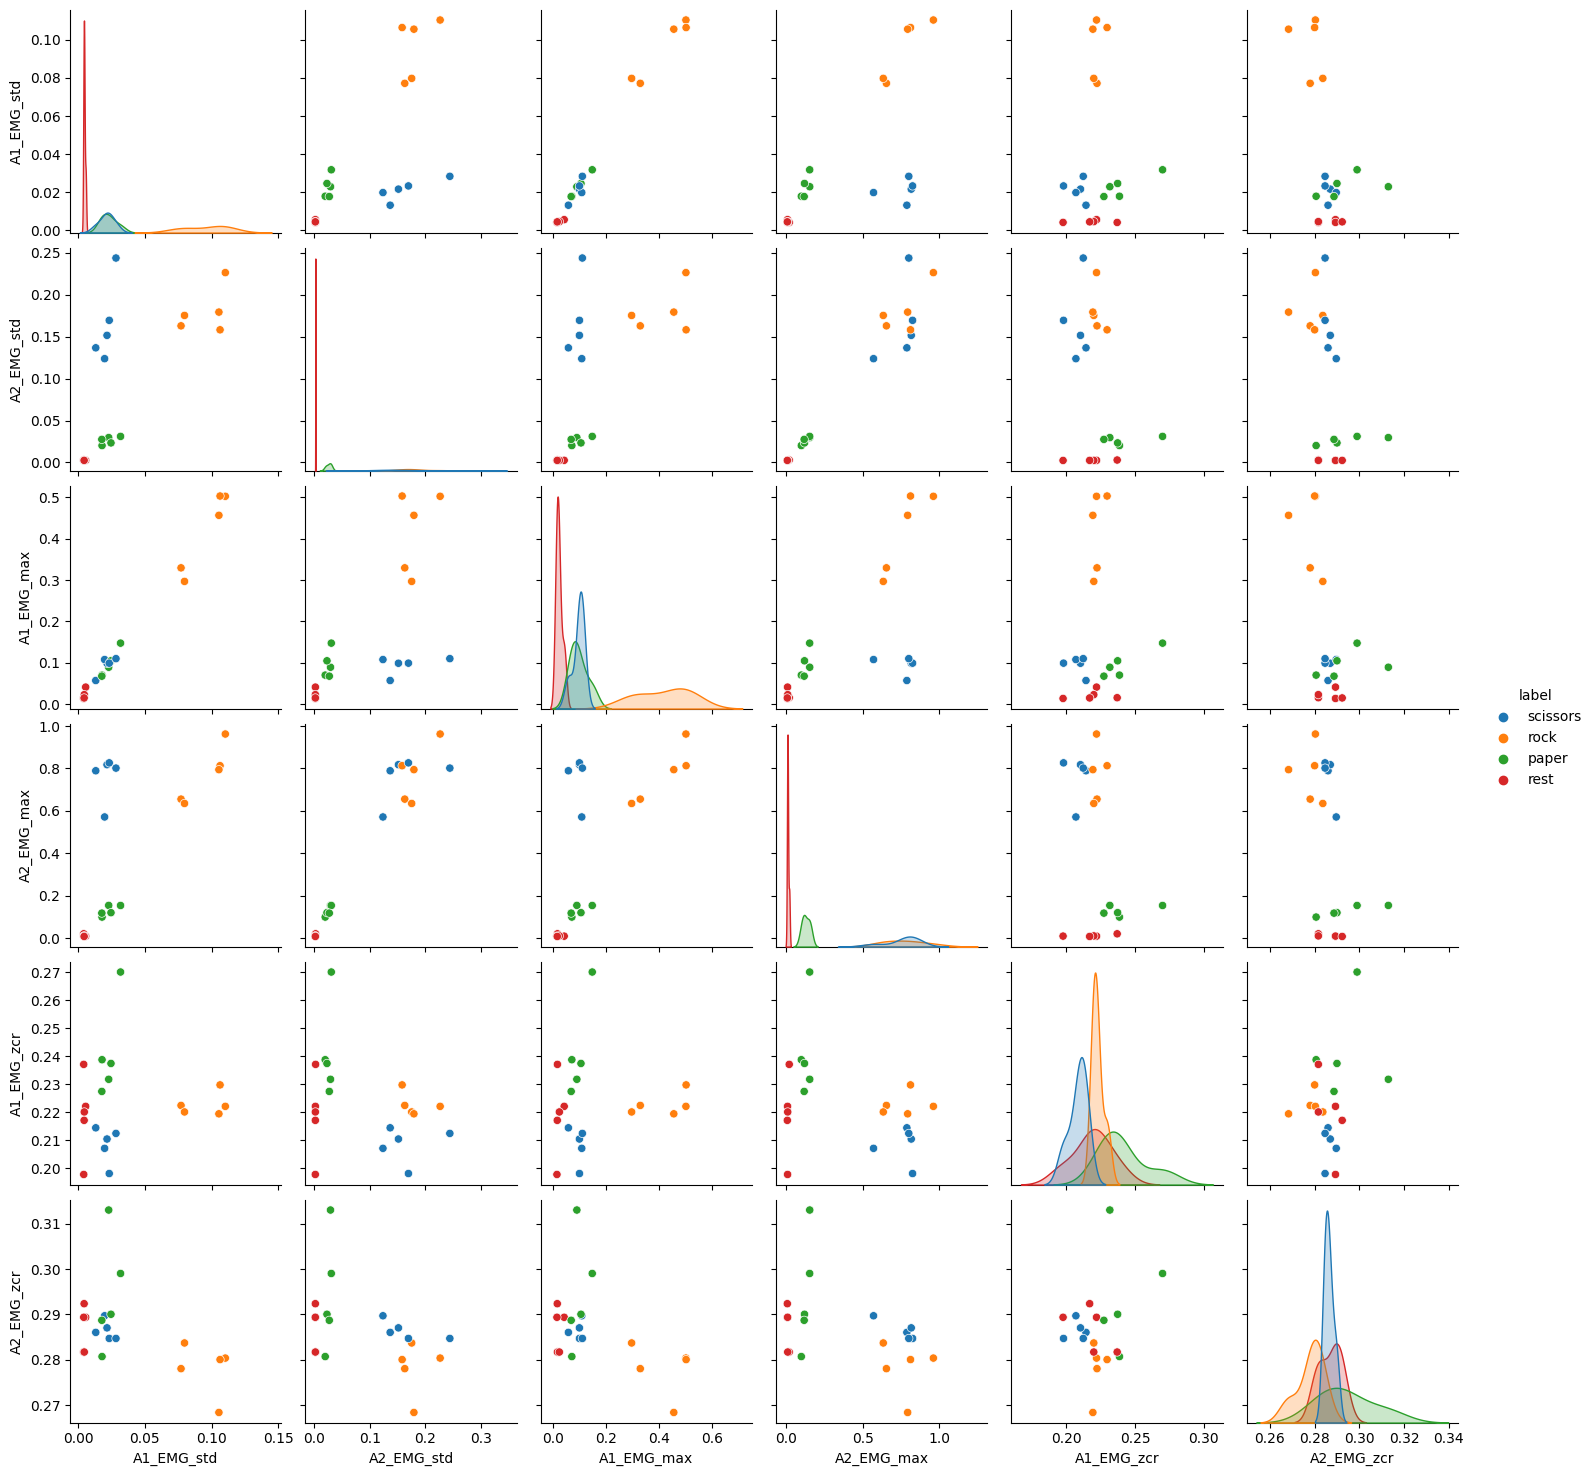

In [6]:
import seaborn as sns
sns.pairplot(df_features, hue='label')  

## See how it classifies the classes 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline(
  steps=[
    ('norm', Normalizer()),
    ('classifier', KNeighborsClassifier())
  ]
)

In [8]:
X = df_features.drop('label', axis=1, inplace=False).values
label_encoder = {label: code for code, label in enumerate(set(df_features.label))}
y = [label_encoder[label] for label in df_features.label.values]

# fit on first 12, and predict last 8
n_predict = 12
pipeline.fit(X[:n_predict,:], y[:n_predict])
y_pred = pipeline.predict(X[n_predict:,:])
y_true = y[n_predict:]

/Users/raph/Code/timeflux/demos/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


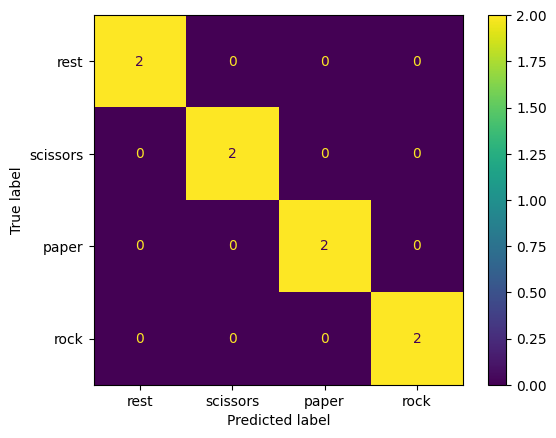

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=list(label_encoder.keys())).plot()